# Segmenting Nerve Structures in Ultrasound Images

This is a quick overview of the code I used during the [Kaggle](https://kaggle.com) [Ultrasound Nerve Segmentation challenge](https://www.kaggle.com/c/ultrasound-nerve-segmentation). It's a modified fork of [Qure-AI](http://blog.qure.ai/)'s [Ultrasound Nerve Segmentation starter code](https://github.com/qureai/ultrasound-nerve-segmentation-using-torchnet) using Torch (luaJIT). 

### Background
The recent [Kaggle](https://kaggle.com) [Ultrasound Nerve Segmentation](https://www.kaggle.com/c/ultrasound-nerve-segmentation) competition provided a chance to apply computer vision in the medical field by identifying nerve structures in ultrasound images. 

An example image:

![png](data/train/images/1_1.png) 

and it's corresponding mask:

![png](data/train/masks/1_1_mask.png)

### Objective
The goal is to train a model that not only detects the nerve structure, but provides a *segmentation* identifying all pixel locations containing the nerve.

### Data
Obviously each ultrasound is actually video. We're given frames from ultrasounds, taken from 47 anonymous patients. For each of the 5,635 training frames given, a mask frame is provided showing the location of the nerve within the frame, if any exists.

To train the model, I used extensive data augmentation including random cropping, elastic transformations consistent with (Ronneberger, Fischer,  Brox, 2015), and vertical and horizontal flips. For each image, the same exact transformation was also applied to the labels. 

##### Data augmentation example

In each batch, a random transformation is applied to each image based on the following pipeline below. As you can see from the 5 random transformations, one image/mask pair can generate quite a few new data pairs with high variation.

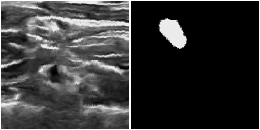

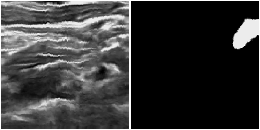

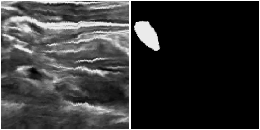

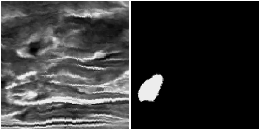

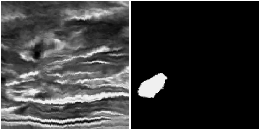

In [1]:
require 'image';
require 'paths';
t=require 'utils/transforms'
require 'dataloader'

train_transforms = GetTrainTransforms{
    t.OneHotLabel(2),
    t.RandomCrop(math.min(3 * imgWidth, trueWidth, trueHeight)),
    t.Resize(imgWidth, imgHeight),
    t.ElasticTransform(200,20),
    t.HorizontalFlip(0.5),
    t.VerticalFlip(0.5),
    t.CatLabel()
}

input = image.load('data/train/images/1_1.png')
input = torch.reshape(input, torch.LongStorage{1, 1, input:size(2), input:size(3)})
mask = image.load('data/train/masks/1_1_mask.png'):float()

for i=1,5 do
    out = train_transforms({input=input, target=mask})
    itorch.image({out['input'], out['target']})
end

### Training / Model Architecture

It probably seems strange that I would want to train a model that's seen images flipped vertically, since this is not likely to happen in a real ultrasound. However, at inference time I can combine an ensemble of predictions from different portions of the image to different rotations from a single model. Thus, training in this way simply uses the shared parameters here to train 4 different models, one for each rotation, at the same time producing features invariant to these rotations, focusing on symmetries.

To pick model fits, I would train each model on approximately 80% of the patients, validating across the other 20% as suggested by [Qure-ai](http://blog.qure.ai/notes/ultrasound-nerve-segmentation-using-torchnet). I picked the best model from each architecture on each train/validation split, to save these for an ensemble prediction later.

The deep networks used were based on the [U-Net](https://arxiv.org/pdf/1505.04597v1.pdf) architecture, *approximately* depicted in the image below [courtesy of (Ronneberger, Fischer,  Brox, 2015)]:

![png](https://github.com/jocicmarko/ultrasound-nerve-segmentation/raw/master/img/u-net-architecture.png)

Note that the actual architectures used here were much smaller. Effectively the architecture works by first iteratively downsampling and convolving the image, where each step the image gets smaller, and the features double. My intuition is that this produces a sort of compression, where hopefully the most important features for this problem are encoded. At each downsampling step, the output is sent both to another downsampling layer and a corresponding upsampling/merge layer, where the network learns to combine both coarse and fine scaled information to determine the best classification at each downsampled pixel. This results in the "U" structure. Another interesting note here is it's faint resemblance to the [Resnet](https://arxiv.org/abs/1512.03385) architecture, which features skip ahead layers such that weights are incentivized to change only when they can improve upon the previous layer (He, Zhang, Ren, Sun, 2015). Here the skips come from much earlier in the net compared the Resnet, but perhaps provide a similar type of incentive towards the lower layers. 

In addition, I added my own "Resunet" architecture, where rather than concatenating and convolving the up-sampled and skip layers to merge, they are simply added, incentivizing the up-sampled layer to provide excess information and reduce complexity.

Overall, the training time for each model took around half a day using a GeForce GTX 970 with 100 epochs using SGD with a learning rate of 0.1. The Resunet was significantly quicker than the U-Net, taking around half of the time and producing very similiar accuracy.

### Inference

As an output, each trained model produces softmax probabilities for each 3x down-sampled patch. To reconstruct a complete mask for the ensemble, I combine the predictions for each model, for each horizonal position in {left, middle-left, middle, middle-right, right}, for each vertical position in {top, middle, bottom}, and for each rotation in {original, horizontal flip, vertical flip}. I do this by taking each pixel probabilities average (which requires counting the number of predictions made for each pixel). If the estimated probability of a nerve pixel is greater than 0.5, the pixel probability is converted to 1, otherwise 0. 

To demonstrate, here's an example of the combined softmax probabilities from the ensemble model (without the threshold of 0.5) (left: ultrasound image, middle: true mask, right: predicted softmax probabilities):

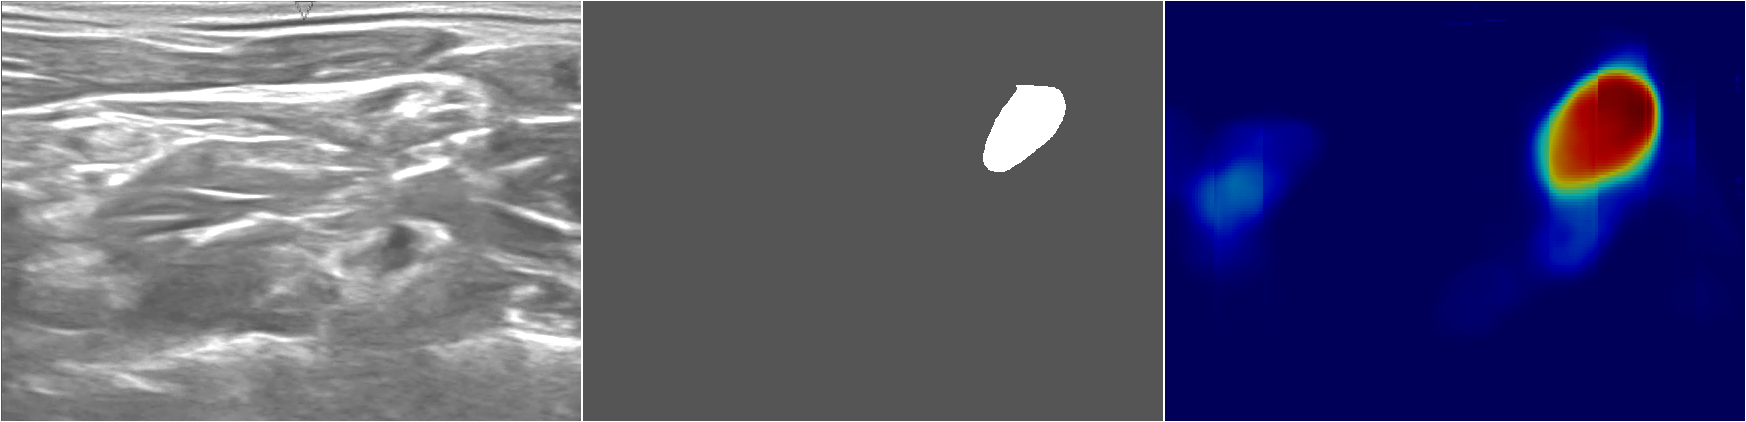

In [2]:
require "ensemble_submission"

--- Simple fix so that itorch.image gets tensors with 3 channels
function withChannels(img) 
    wc = torch.Tensor(3, img:size(1), img:size(2))
    for i=1,3 do
        wc[i]:copy(img)
    end
    return wc
end

--- Returns plot of Image, Mask, Prediction
function getPrediction(input, mask, threshold)
    
    output = GetSegmentationModelOutputs('data/best_models', input[1][1], threshold, true)
    
    return itorch.image({
        withChannels(input[1][1]), 
        withChannels(mask[1]), 
        image.y2jet(255 * output + 1) - 0.5
    })
end

getPrediction(input, mask) 

Now with the softmax threshold of 0.5:

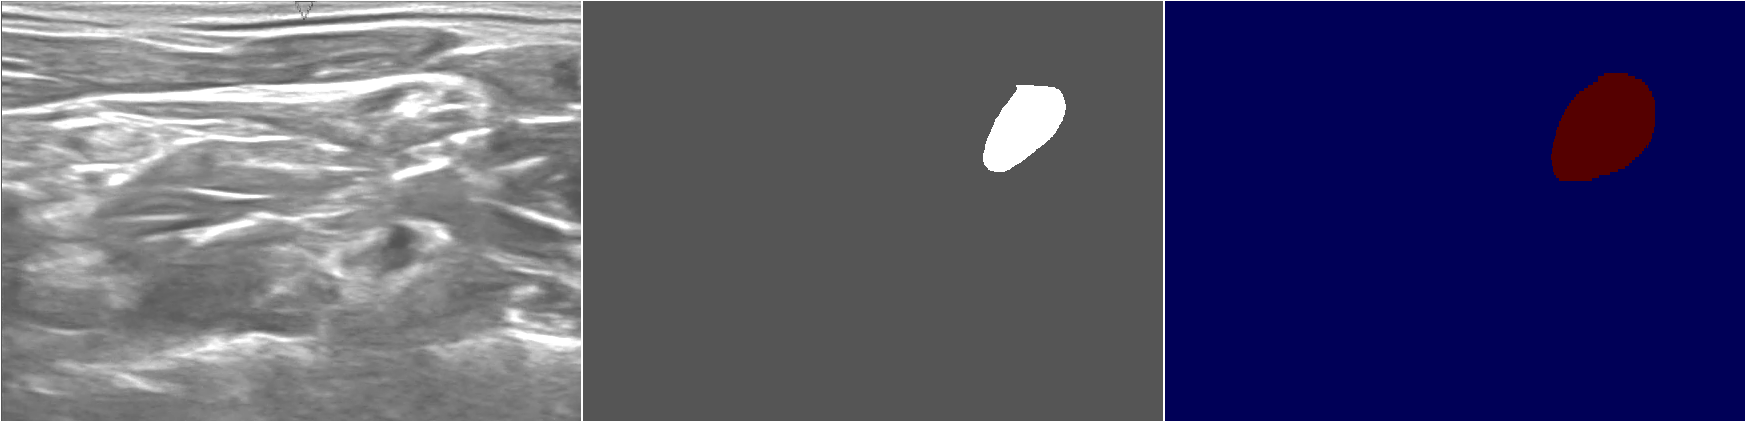

In [3]:
getPrediction(input, mask, 0.5) 

### Results

CURSES KAGGLE!!!! Unfortunately, I overlooked the ["soft" deadline](https://www.kaggle.com/c/ultrasound-nerve-segmentation/rules) for a first submission, as well as started with 20 days to go (7/30/16). Without even knowing there was a "soft" deadline, I attempted to upload my first submission a day after I was unable to enter the competition (evidenced by my test_submission.csv timestamped at 2016-8-13 8:50:27 AM ET). That means I will never get to see how my model ran on the test set, which after 2 weeks of non-stop training the models before/after work, is perhaps the most frustating thing imaginable. 
 By the way, who sets a "soft" deadline the day before the weekend?

In retrospect, the best thing I can do now is share my findings and approach. I think this is incredibly interesting and useful for anyone either currently researching image segmenting algorithms or someone else who didn't even realize they could be doing this. I also think this code makes it even easier to get started.

Finally, this example will remain in my heart as the #1 lesson of why (beyond checking for "soft" deadlines) it's always best to finish an entire working pipeline front to end first before tweaking... Let this be a warning.